# ☀️ Solar Power Generation Prediction

This project uses environmental data to predict **solar power output** at a solar plant in Berkeley, CA. The dataset includes the following variables:

## 🌤 Input Features
- **🌞 distance_to_solar_noon** – Distance to solar noon (radians)  
- **🌡 temperature** – Daily average temperature (°C)  
- **🧭 wind_direction** – Daily average wind direction (°; 0–360)  
- **💨 wind_speed** – Daily average wind speed (m/s)  
- **☁️ sky_cover** – Cloud cover (0 = clear, 4 = fully covered)  
- **👀 visibility** – Visibility (km)  
- **💧 humidity** – Relative humidity (%)  
- **🌬 average_wind_speed** – 3-hour average wind speed (m/s)  
- **🌡️ average_pressure** – 3-hour average barometric pressure (inHg)  

## ⚡ Target Variable
- **🔋 power_generated** – Power generated in each 3-hour period (J)  

## 🎯 Project Goal
The goal is to predict power output under different environmental conditions to optimize solar plant performance.  
This project leverages machine learning techniques, including:
- **Feature Engineering**  
- **Residual Modeling**  
- **XGBoost Regression**  
- **Weighted LSTM Sequence Correction** – gently smooths XGBoost residuals over time for improved trend prediction.

These methods capture complex relationships between weather variables and energy production, while preserving sudden drops and short-term variability.

## 💡 Inspiration
The project was inspired by methodologies implemented in [**Neural Designer**](https://www.neuraldesigner.com/learning/examples/solar-power-generation/), which applied a neural network to model solar power generation from environmental data.

## 📊 Highlights
- Baseline MAE: `2052.22`  
- XGBoost MAE: `571.93`  
- Weighted LSTM sequence correction MAE: `625.96` (alpha = 0.2)  
- Visualizations include:
  - **Time series plots** for first & last 15 days comparing Baseline, XGBoost, and XGB + Weighted LSTM predictions  
  - **Polar plots** for Solar Noon & Wind Direction, showing absolute errors for Baseline, XGBoost, and XGB + Weighted LSTM  

**Note:** Weighted LSTM residual correction smooths minor fluctuations without overcorrecting sudden drops, providing a stable, realistic forecast while retaining XGBoost’s accuracy for abrupt events.

---

## 📝 Conclusion / Next Steps
- **Conclusion:** XGBoost captures the majority of solar power variability, while the weighted LSTM sequence improves trend smoothness and residual modeling without overfitting. Visualizations confirm that the combined approach preserves sudden drops and daily patterns.  
- **Next Steps:**  
  1. Incorporate environmental features into the LSTM input for more anticipatory corrections.  
  2. Explore hyperparameter tuning for sequence length, hidden size, and alpha weighting.  
  3. Evaluate performance on longer forecast horizons (multi-step ahead predictions).  
  4. Investigate additional residual modeling techniques, such as convolutional LSTMs or attention mechanisms, for capturing short-term spikes and drops more accurately.


0️⃣ Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error

import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader

import xgboost as xgb

sns.set(style="whitegrid")
plt.rcParams.update({'font.size': 12})


1️⃣ Load & Clean Data

In [2]:
url = "https://docs.google.com/spreadsheets/d/1GQinXQW_HA-lyZ6YOAbsWJqLkMX6uFSShE7Qh0SYEO8/export?format=csv"
df = pd.read_csv(url)

# Interpolate missing wind speed
df['average-wind-speed-(period)'] = df['average-wind-speed-(period)'].interpolate(method='linear')


2️⃣ Feature Engineering

In [3]:
#Cyclical Features
df['wind_dir_sin'] = np.sin(2 * np.pi * df['wind-direction'] / 36)
df['wind_dir_cos'] = np.cos(2 * np.pi * df['wind-direction'] / 36)
df.drop(columns=['wind-direction'], inplace=True)

df['solar_noon_sin'] = np.sin(2 * np.pi * df['distance-to-solar-noon'])
df['solar_noon_cos'] = np.cos(2 * np.pi * df['distance-to-solar-noon'])
df.drop(columns=['distance-to-solar-noon'], inplace=True)


In [4]:
#Interaction Features
df['temp_wind'] = df['temperature'] * df['average-wind-speed-(period)']
df['sky_visibility'] = (4 - df['sky-cover']) * df['visibility']

# One-hot encode sky-cover
df = pd.get_dummies(df, columns=['sky-cover'], prefix='sky', drop_first=True)


In [5]:
df.head(15)

,temperature,wind-speed,visibility,humidity,average-wind-speed-(period),average-pressure-(period),power-generated,wind_dir_sin,wind_dir_cos,solar_noon_sin,solar_noon_cos,temp_wind,sky_visibility,sky_1,sky_2,sky_3,sky_4
0,69,7.5,10.0,75,8.0,29.82,0,-0.984808,0.173648,-0.770925,0.636926,552.0,40.0,False,False,False,False
1,69,7.5,10.0,77,5.0,29.85,0,-0.984808,0.173648,-0.722635,-0.691229,345.0,40.0,False,False,False,False
2,69,7.5,10.0,70,0.0,29.89,5418,-0.984808,0.173648,0.602066,-0.798446,0.0,40.0,False,False,False,False
3,69,7.5,10.0,33,0.0,29.91,25477,-0.984808,0.173648,0.863321,0.504655,0.0,40.0,False,False,False,False
4,69,7.5,10.0,21,3.0,29.89,30069,-0.984808,0.173648,0.400333,0.916370,207.0,40.0,False,False,False,False
5,69,7.5,10.0,20,23.0,29.85,16280,-0.984808,0.173648,0.956867,-0.290526,1587.0,40.0,False,False,False,False
6,69,7.5,10.0,36,15.0,29.83,515,-0.984808,0.173648,-0.176740,-0.984258,1035.0,40.0,False,False,False,False
7,69,7.5,10.0,49,6.0,29.86,0,-0.984808,0.173648,-0.998166,0.060534,414.0,40.0,False,False,False,False
8,72,6.8,10.0,67,6.0,29.86,0,-0.939693,0.342020,-0.761981,0.647599,432.0,40.0,False,False,False,False
9,72,6.8,10.0,49,0.0,29.87,0,-0.939693,0.342020,-0.729633,-0.683838,0.0,40.0,False,False,False,False


3️⃣ Clear-Sky Baseline & Residuals

In [6]:
steps_per_day = 8
num_days = len(df) // steps_per_day
lookback_days = 3
alpha = 0.3

power_matrix = df['power-generated'].values[:num_days*steps_per_day].reshape(num_days, steps_per_day)
baseline_matrix = np.zeros_like(power_matrix)

# Seed first few days
for day in range(lookback_days):
    baseline_matrix[day] = power_matrix[day]

# Adaptive baseline for remaining days
for day in range(lookback_days, num_days):
    prev_baseline = baseline_matrix[day-1]
    window = power_matrix[day - lookback_days: day]
    stepwise_max = np.max(window, axis=0)
    delta = stepwise_max - prev_baseline
    alpha_eff = np.where(delta > 0, alpha, alpha * 0.5)
    baseline_matrix[day] = prev_baseline + alpha_eff * delta

df['baseline_clear_sky_peak3'] = baseline_matrix.flatten()
df['residual_clear_sky_peak3'] = df['power-generated'].values[:num_days*steps_per_day] - df['baseline_clear_sky_peak3']


4️⃣ Exploratory Plots

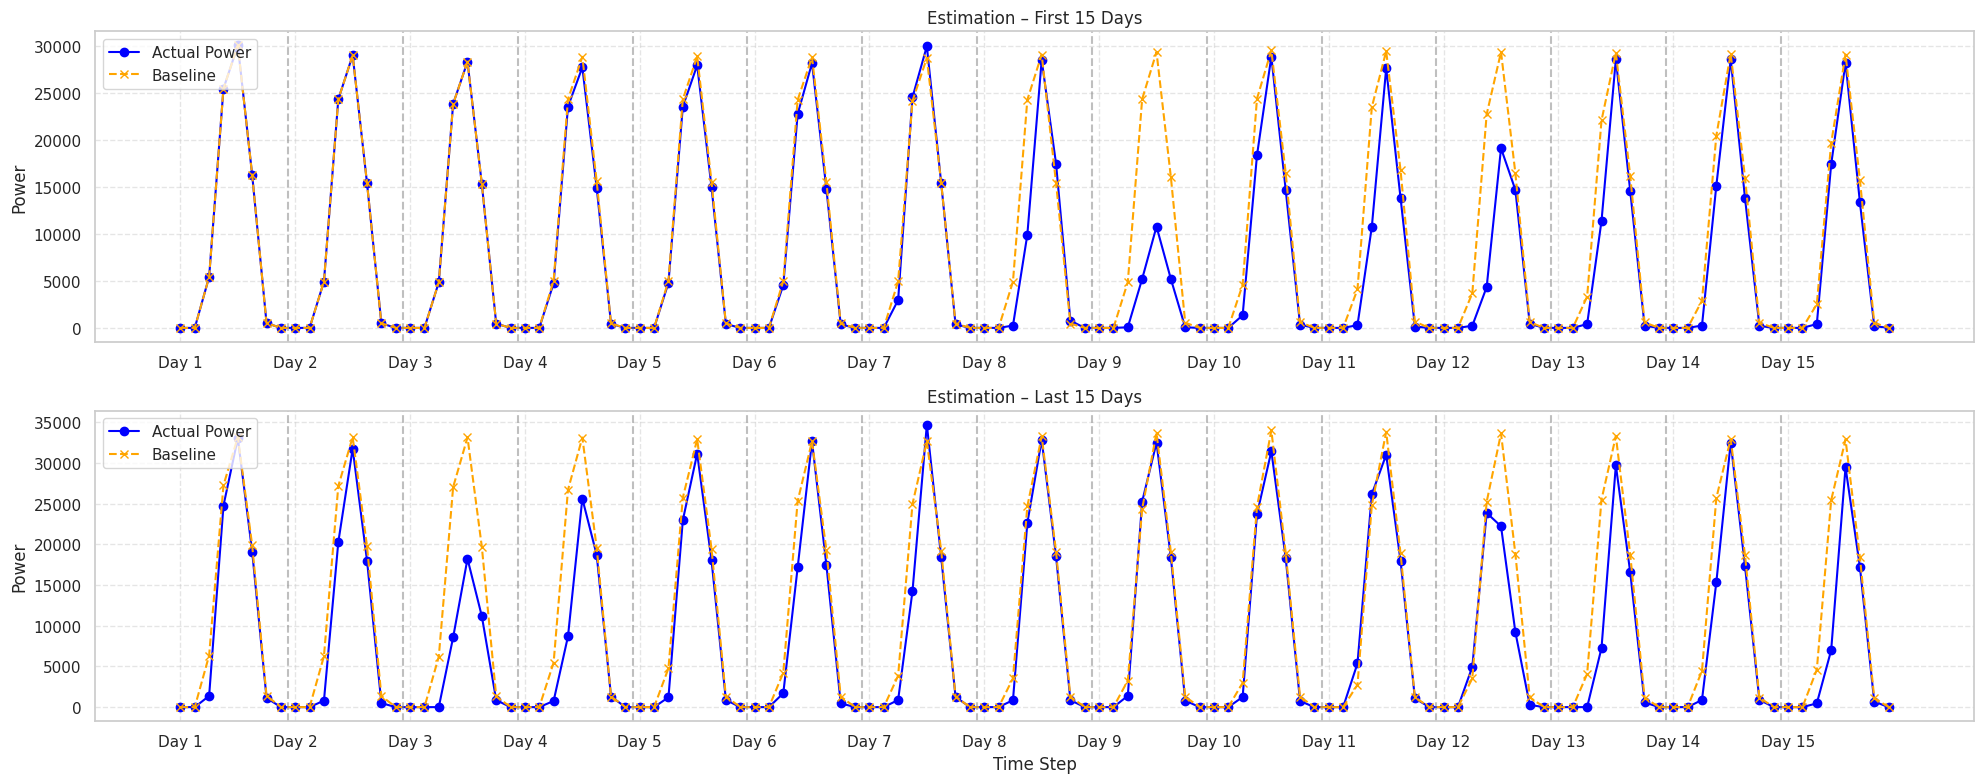

In [7]:
def plot_power_vs_baseline_edges(df, steps_per_day=8, days_per_plot=15):
    num_full_days = len(df) // steps_per_day
    total_steps = num_full_days * steps_per_day

    slices = [
        (0, days_per_plot * steps_per_day, "Estimation – First 15 Days"),
        (total_steps - days_per_plot * steps_per_day, total_steps, "Estimation – Last 15 Days")
    ]

    plt.figure(figsize=(20, 8))
    for i, (start_idx, end_idx, title) in enumerate(slices):
        df_plot = df.iloc[start_idx:end_idx]
        ax = plt.subplot(len(slices), 1, i + 1)
        ax.plot(df_plot['power-generated'].values, label='Actual Power', color='blue', marker='o')
        ax.plot(df_plot['baseline_clear_sky_peak3'].values, label='Baseline', color='orange', linestyle='--', marker='x')
        for day in range(1, days_per_plot):
            ax.axvline(x=day * steps_per_day - 0.5, color='gray', linestyle='--', alpha=0.5)
        ax.set_xticks(np.arange(0, days_per_plot * steps_per_day, steps_per_day))
        ax.set_xticklabels([f'Day {d+1}' for d in range(days_per_plot)], rotation=0)
        ax.set_ylabel('Power')
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper left')
    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()

plot_power_vs_baseline_edges(df)


5️⃣ Lag Features for ML Models

In [8]:
lags = [1,2,3,8,16,24]
for lag in lags:
    df[f'lag{lag}_power'] = df['power-generated'].shift(lag).fillna(df['baseline_clear_sky_peak3'])


6️⃣ Features & Target Preparation

In [9]:
features = ['temperature','wind-speed','visibility','humidity',
            'average-wind-speed-(period)','average-pressure-(period)',
            'wind_dir_sin','wind_dir_cos','solar_noon_sin','solar_noon_cos',
            'temp_wind','sky_visibility','sky_1','sky_2','sky_3','sky_4'] + \
           [f'lag{lag}_power' for lag in lags]

df['temp_wind_interaction'] = df['temperature'] * df['wind-speed']
df['solar_sky_interaction'] = df['solar_noon_sin'] * df['sky_visibility']
features += ['temp_wind_interaction','solar_sky_interaction']

X = df[features].values
y = df['residual_clear_sky_peak3'].values


7️⃣ Train/Test Split

In [10]:
split_idx = int(0.8 * len(df))
X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]


8️⃣ XGBoost Residual Model

In [11]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
dfull = xgb.DMatrix(X)

params = {
    "objective": "reg:squarederror",
    "max_depth": 6,
    "eta": 0.05,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "lambda": 2,
    "alpha": 1,
    "eval_metric": "mae",
    "seed": 42
}

evals = [(dtrain, "train"), (dval, "val")]
evals_result = {}

xgb_model = xgb.train(
    params,
    dtrain,
    num_boost_round=500,
    evals=evals,
    early_stopping_rounds=20,
    verbose_eval=20,
    evals_result=evals_result  # store MAE for plotting
)

y_pred_residual = xgb_model.predict(dfull)
df['power_pred_xgb'] = df['baseline_clear_sky_peak3'] + y_pred_residual
df['power_pred_xgb_clipped'] = df['power_pred_xgb'].clip(lower=0)


[0]	train-mae:2808.64466	val-mae:2316.41231
[20]	train-mae:1479.28898	val-mae:1526.68982
[40]	train-mae:947.14709	val-mae:1253.71542
[60]	train-mae:696.77498	val-mae:1168.47721
[80]	train-mae:565.45972	val-mae:1155.61679
[100]	train-mae:489.89060	val-mae:1147.19140
[117]	train-mae:445.62416	val-mae:1150.02443


9️⃣ Evaluate Model

In [12]:
mae_baseline = mean_absolute_error(df['power-generated'], df['baseline_clear_sky_peak3'])
mae_xgb = mean_absolute_error(df['power-generated'], df['power_pred_xgb_clipped'])
print(f"Baseline MAE: {mae_baseline:.2f}")
print(f"XGBoost MAE: {mae_xgb:.2f}")

Baseline MAE: 2052.22
XGBoost MAE: 571.93


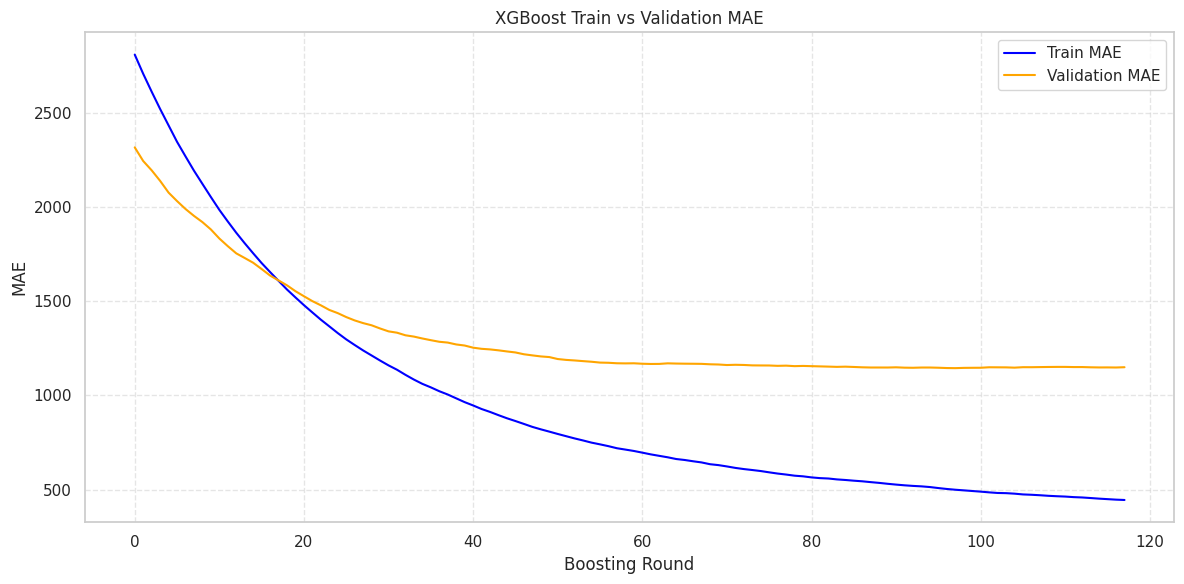

In [13]:
plt.figure(figsize=(12,6))
plt.plot(evals_result['train']['mae'], label='Train MAE', color='blue')
plt.plot(evals_result['val']['mae'], label='Validation MAE', color='orange')
plt.xlabel('Boosting Round')
plt.ylabel('MAE')
plt.title('XGBoost Train vs Validation MAE')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()


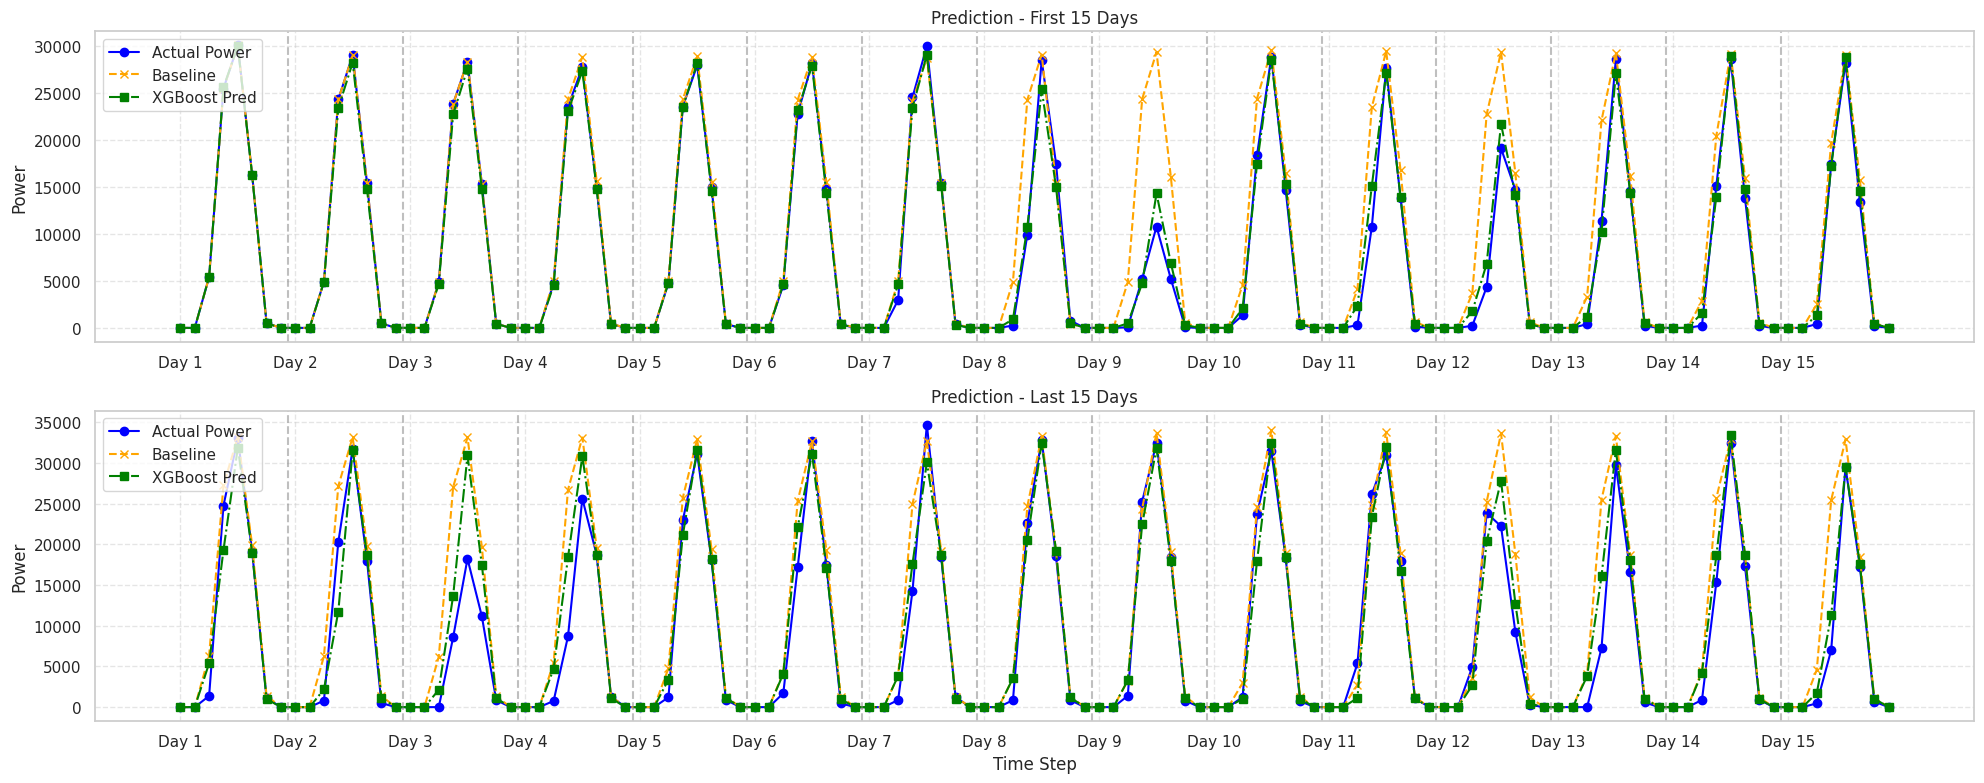

In [14]:
def plot_power_vs_baseline_vs_xgb(df, steps_per_day=8, days_per_plot=15):
    num_full_days = len(df) // steps_per_day
    total_steps = num_full_days * steps_per_day

    slices = [
        (0, days_per_plot * steps_per_day, "Prediction - First 15 Days"),
        (total_steps - days_per_plot * steps_per_day, total_steps, "Prediction - Last 15 Days")
    ]

    plt.figure(figsize=(20, 8))

    for i, (start_idx, end_idx, title) in enumerate(slices):
        df_plot = df.iloc[start_idx:end_idx]
        ax = plt.subplot(len(slices), 1, i + 1)

        # Plot actual power
        ax.plot(df_plot['power-generated'].values, label='Actual Power', color='blue', marker='o')
        # Plot baseline
        ax.plot(df_plot['baseline_clear_sky_peak3'].values, label='Baseline', color='orange', linestyle='--', marker='x')
        # Plot XGBoost predictions
        ax.plot(df_plot['power_pred_xgb_clipped'].values, label='XGBoost Pred', color='green', linestyle='-.', marker='s')

        # Vertical lines to separate days
        for day in range(1, days_per_plot):
            ax.axvline(x=day * steps_per_day - 0.5, color='gray', linestyle='--', alpha=0.5)

        # X-axis ticks at the start of each day
        ax.set_xticks(np.arange(0, days_per_plot * steps_per_day, steps_per_day))
        ax.set_xticklabels([f'Day {d+1}' for d in range(days_per_plot)], rotation=0)

        ax.set_ylabel('Power')
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper left')

    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()

# Call the function
plot_power_vs_baseline_vs_xgb(df)


In [15]:
df.columns

Index(['temperature', 'wind-speed', 'visibility', 'humidity',
       'average-wind-speed-(period)', 'average-pressure-(period)',
       'power-generated', 'wind_dir_sin', 'wind_dir_cos', 'solar_noon_sin',
       'solar_noon_cos', 'temp_wind', 'sky_visibility', 'sky_1', 'sky_2',
       'sky_3', 'sky_4', 'baseline_clear_sky_peak3',
       'residual_clear_sky_peak3', 'lag1_power', 'lag2_power', 'lag3_power',
       'lag8_power', 'lag16_power', 'lag24_power', 'temp_wind_interaction',
       'solar_sky_interaction', 'power_pred_xgb', 'power_pred_xgb_clipped'],
      dtype='object')

1️⃣1️⃣ Polar Plots: Solar Noon & Wind Direction

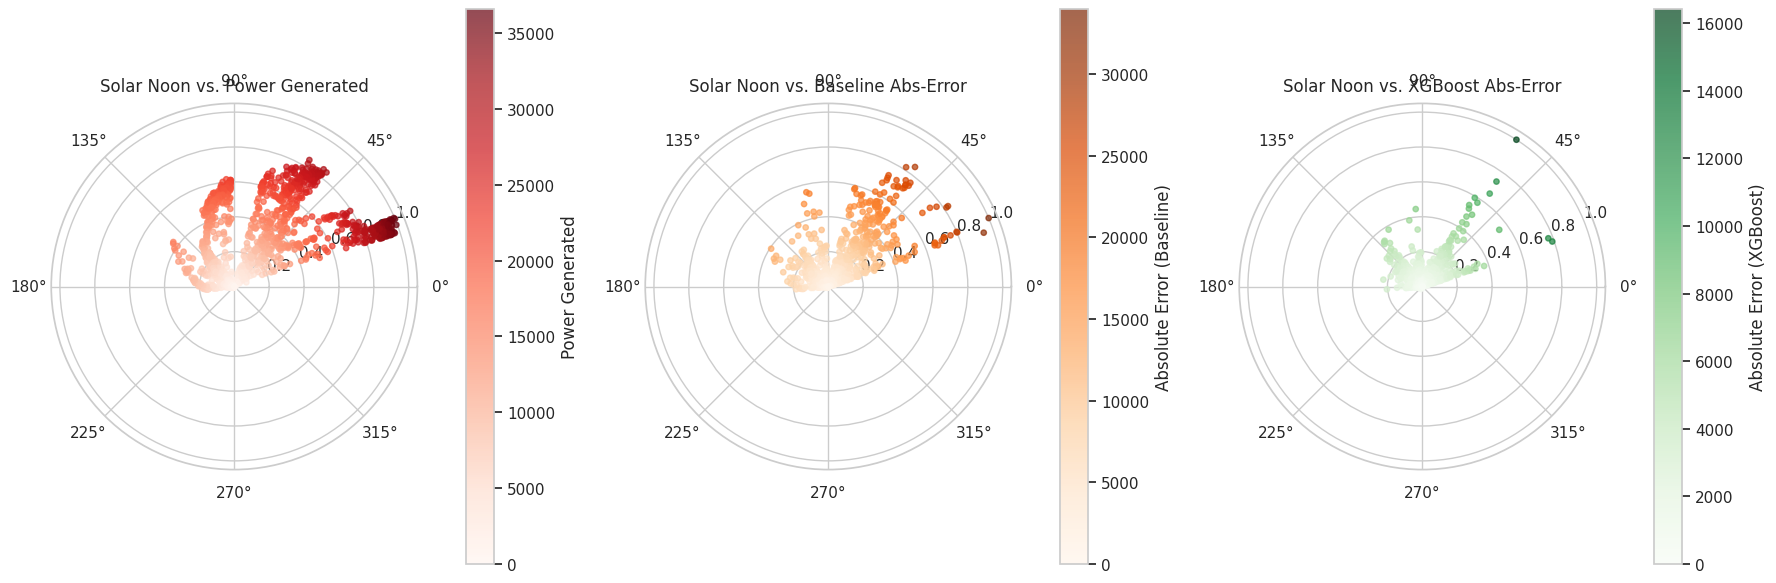

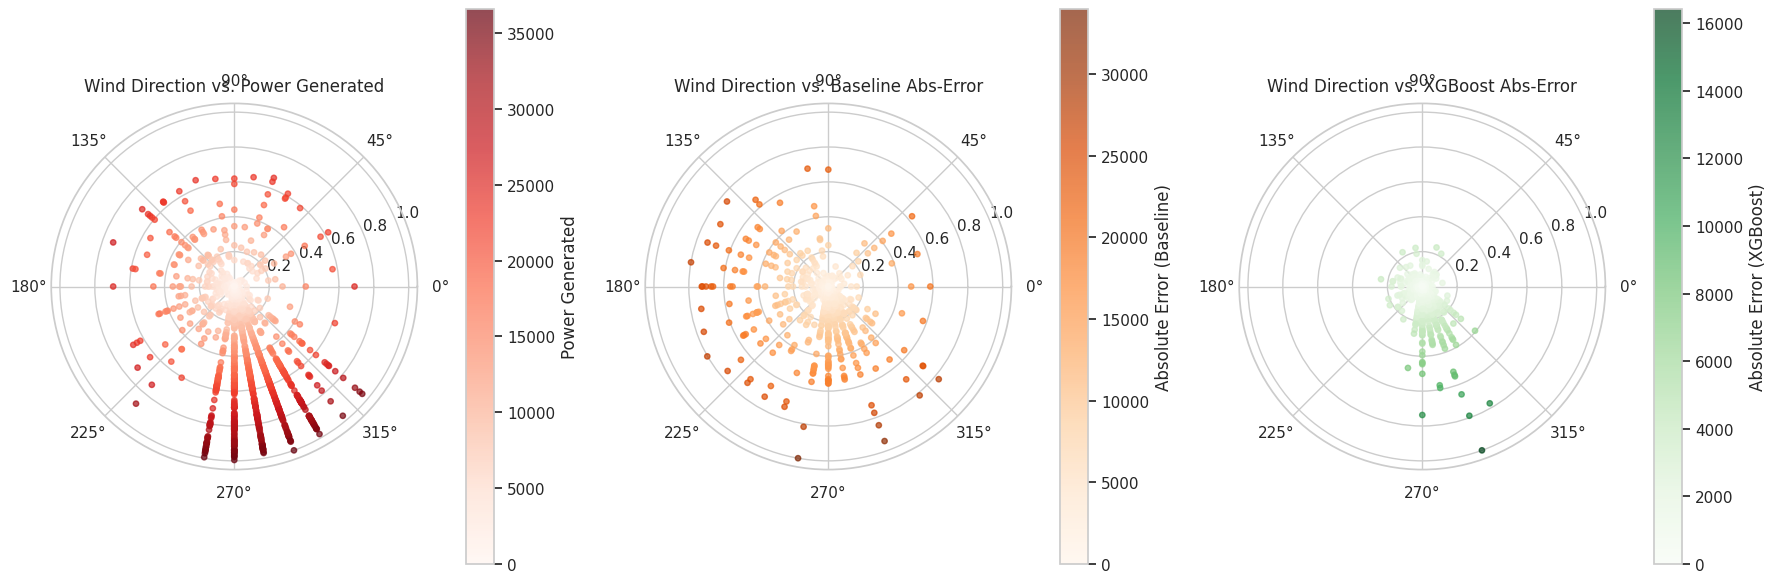

In [16]:
def plot_polar_errors(df, angle_sin, angle_cos, title_prefix):
    theta = np.arctan2(df[angle_sin], df[angle_cos]) % (2*np.pi)
    r_power = df['power-generated'].values.reshape(-1,1)
    r_baseline_error = np.abs(df['power-generated'] - df['baseline_clear_sky_peak3']).values.reshape(-1,1)
    r_xgb_error = np.abs(df['power-generated'] - df['power_pred_xgb_clipped']).values.reshape(-1,1)

    scaler = MinMaxScaler()
    r_power_scaled = scaler.fit_transform(r_power).flatten()
    r_baseline_scaled = scaler.fit_transform(r_baseline_error).flatten()
    r_xgb_scaled = scaler.fit_transform(r_xgb_error).flatten()

    plt.figure(figsize=(18,6))

    ax1 = plt.subplot(1,3,1, polar=True)
    sc1 = ax1.scatter(theta, r_power_scaled, c=r_power.flatten(), cmap='Reds', alpha=0.7, s=15)
    ax1.set_title(f"{title_prefix} vs. Power Generated", va='bottom')
    plt.colorbar(sc1, ax=ax1, pad=0.1, label='Power Generated')

    ax2 = plt.subplot(1,3,2, polar=True)
    sc2 = ax2.scatter(theta, r_baseline_scaled, c=r_baseline_error.flatten(), cmap='Oranges', alpha=0.7, s=15)
    ax2.set_title(f"{title_prefix} vs. Baseline Abs-Error", va='bottom')
    plt.colorbar(sc2, ax=ax2, pad=0.1, label='Absolute Error (Baseline)')

    ax3 = plt.subplot(1,3,3, polar=True)
    sc3 = ax3.scatter(theta, r_xgb_scaled, c=r_xgb_error.flatten(), cmap='Greens', alpha=0.7, s=15)
    ax3.set_title(f"{title_prefix} vs. XGBoost Abs-Error", va='bottom')
    plt.colorbar(sc3, ax=ax3, pad=0.1, label='Absolute Error (XGBoost)')

    plt.tight_layout()
    plt.show()

# Solar Noon
plot_polar_errors(df, 'solar_noon_sin', 'solar_noon_cos', "Solar Noon")

# Wind Direction
plot_polar_errors(df, 'wind_dir_sin', 'wind_dir_cos', "Wind Direction")


In [23]:
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

# =============================
# 1️⃣ Scale residuals
# =============================
residuals = df['residual_clear_sky_peak3'].values.reshape(-1, 1)
scaler_res = StandardScaler()
residuals_scaled = scaler_res.fit_transform(residuals).flatten()

sequence_length = 8  # last 8 timesteps (~1 day)

# =============================
# 2️⃣ Create sequences
# =============================
X_seq, y_seq = [], []
for i in range(sequence_length, len(residuals_scaled)):
    X_seq.append(residuals_scaled[i-sequence_length:i])
    y_seq.append(residuals_scaled[i])

X_seq = np.array(X_seq)[:, :, np.newaxis]  # shape (samples, seq_len, 1)
y_seq = np.array(y_seq)

# =============================
# 3️⃣ Train/Validation split
# =============================
split_idx = int(0.8 * len(X_seq))
X_train_seq, X_val_seq = X_seq[:split_idx], X_seq[split_idx:]
y_train_seq, y_val_seq = y_seq[:split_idx], y_seq[split_idx:]

X_train_seq = torch.tensor(X_train_seq, dtype=torch.float32)
y_train_seq = torch.tensor(y_train_seq, dtype=torch.float32).unsqueeze(1)
X_val_seq = torch.tensor(X_val_seq, dtype=torch.float32)
y_val_seq = torch.tensor(y_val_seq, dtype=torch.float32).unsqueeze(1)

train_loader = DataLoader(TensorDataset(X_train_seq, y_train_seq), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_seq, y_val_seq), batch_size=32)

# =============================
# 4️⃣ Lightweight LSTM
# =============================
class ResidualLSTM(nn.Module):
    def __init__(self, input_size=1, hidden_size=16, num_layers=1):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.fc(out[:, -1, :])

model = ResidualLSTM()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# =============================
# 5️⃣ Train LSTM
# =============================
num_epochs = 50
for epoch in range(num_epochs):
    # Train
    model.train()
    train_loss = 0
    for xb, yb in train_loader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * xb.size(0)
    train_loss /= len(train_loader.dataset)

    # Validation
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for xb, yb in val_loader:
            pred = model(xb)
            loss = criterion(pred, yb)
            val_loss += loss.item() * xb.size(0)
    val_loss /= len(val_loader.dataset)

    if (epoch+1) % 10 == 0:
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")

# =============================
# 6️⃣ Predict sequence residuals
# =============================
model.eval()
X_full_seq = torch.tensor(X_seq, dtype=torch.float32)
seq_residual_pred_scaled = model(X_full_seq).detach().numpy().flatten()
seq_residual_pred = scaler_res.inverse_transform(seq_residual_pred_scaled.reshape(-1,1)).flatten()

# =============================
# 7️⃣ Weighted addition to XGBoost predictions
# =============================
alpha = 0.2  # choose value in 0.1–0.3

df_seq_pred = df.iloc[sequence_length:].copy()
df_seq_pred.loc[:, 'power_pred_seq_weighted'] = (
    df_seq_pred['power_pred_xgb_clipped'].values + alpha * seq_residual_pred
)
df_seq_pred.loc[:, 'power_pred_seq_weighted_clipped'] = df_seq_pred['power_pred_seq_weighted'].clip(0)

# =============================
# 8️⃣ Evaluate
# =============================
mae_weighted = mean_absolute_error(df_seq_pred['power-generated'], df_seq_pred['power_pred_seq_weighted_clipped'])
print(f"MAE with weighted LSTM correction (alpha={alpha}): {mae_weighted:.2f}")


Epoch 10/50, Train Loss: 0.491524, Val Loss: 0.468587
Epoch 20/50, Train Loss: 0.447902, Val Loss: 0.445199
Epoch 30/50, Train Loss: 0.429783, Val Loss: 0.429420
Epoch 40/50, Train Loss: 0.421103, Val Loss: 0.424696
Epoch 50/50, Train Loss: 0.408734, Val Loss: 0.413934
MAE with weighted LSTM correction (alpha=0.2): 625.96


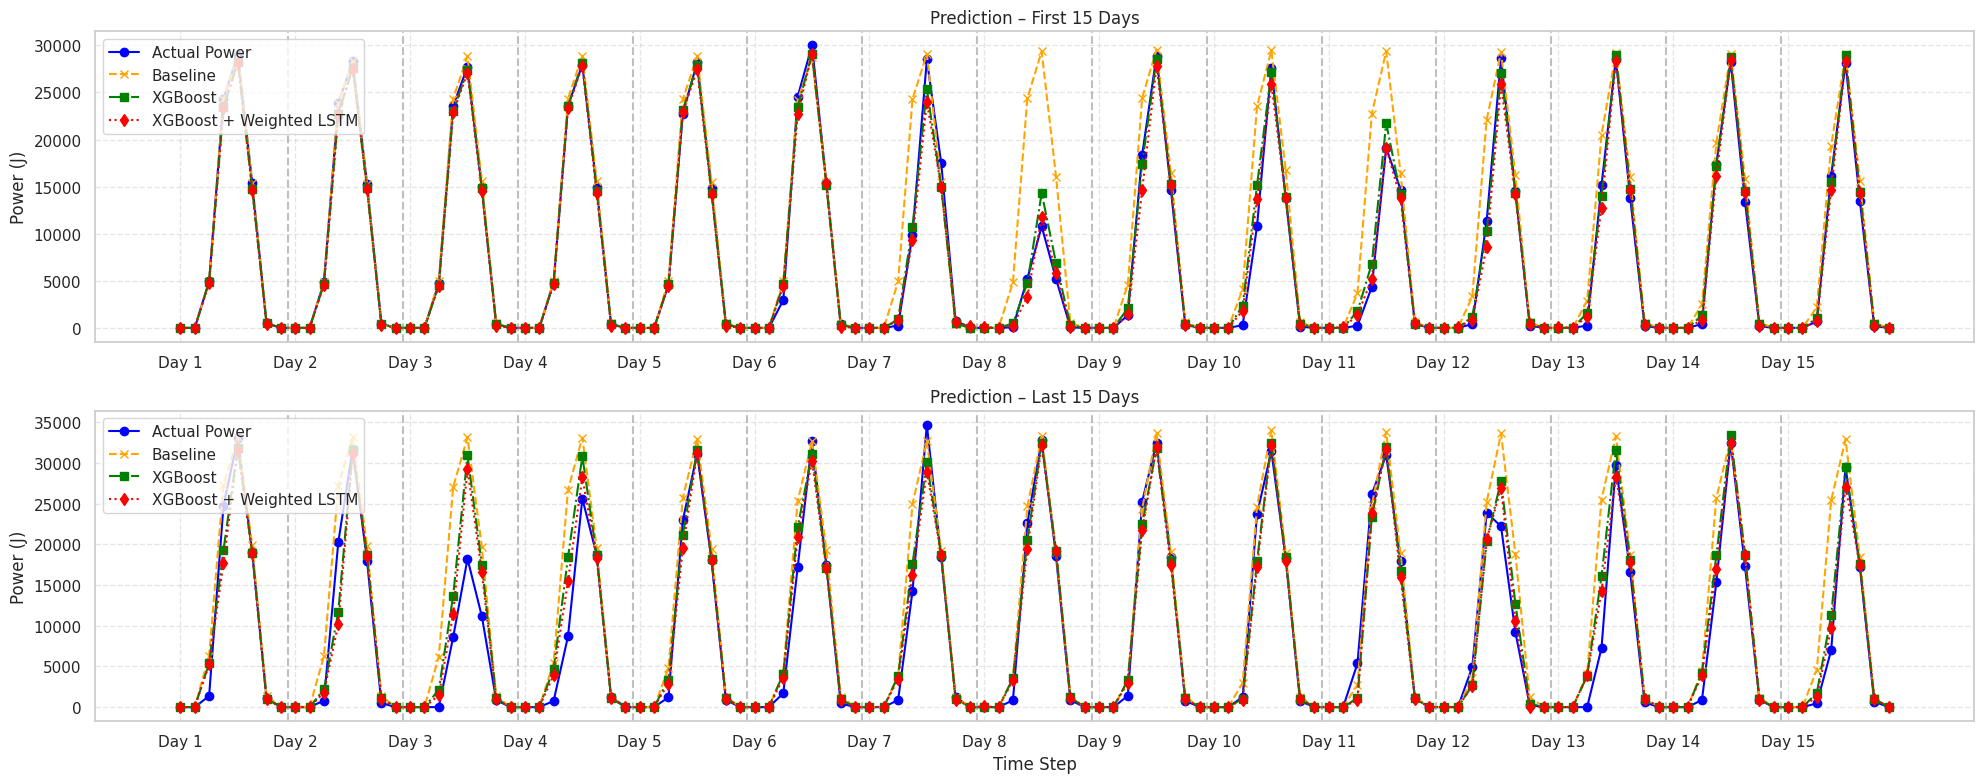

In [25]:
import matplotlib.pyplot as plt

def plot_predictions_weighted_lstm(df, seq_df, steps_per_day=8, days_per_plot=15):
    """
    Plot Baseline vs XGBoost vs Weighted LSTM sequence predictions.

    Parameters:
        df : pd.DataFrame
            Original dataframe with baseline and XGBoost predictions.
        seq_df : pd.DataFrame
            DataFrame with weighted LSTM sequence predictions.
        steps_per_day : int
            Number of timesteps per day.
        days_per_plot : int
            Number of days to plot at start and end.
    """
    num_full_days = len(seq_df) // steps_per_day
    total_steps = num_full_days * steps_per_day

    slices = [
        (0, days_per_plot * steps_per_day, "Prediction – First 15 Days"),
        (total_steps - days_per_plot * steps_per_day, total_steps, "Prediction – Last 15 Days")
    ]

    plt.figure(figsize=(20, 8))

    for i, (start_idx, end_idx, title) in enumerate(slices):
        df_plot = seq_df.iloc[start_idx:end_idx]
        ax = plt.subplot(len(slices), 1, i + 1)

        # Actual power
        ax.plot(df_plot['power-generated'].values, label='Actual Power', color='blue', marker='o')
        # Baseline
        ax.plot(df_plot['baseline_clear_sky_peak3'].values, label='Baseline', color='orange', linestyle='--', marker='x')
        # XGBoost
        ax.plot(df_plot['power_pred_xgb_clipped'].values, label='XGBoost', color='green', linestyle='-.', marker='s')
        # Weighted LSTM sequence
        ax.plot(seq_df['power_pred_seq_weighted_clipped'].values[start_idx:end_idx],
                label='XGBoost + Weighted LSTM', color='red', linestyle=':', marker='d')

        # Vertical lines separating days
        for day in range(1, days_per_plot):
            ax.axvline(x=day * steps_per_day - 0.5, color='gray', linestyle='--', alpha=0.5)

        # X-axis ticks
        ax.set_xticks(np.arange(0, days_per_plot * steps_per_day, steps_per_day))
        ax.set_xticklabels([f'Day {d+1}' for d in range(days_per_plot)], rotation=0)

        ax.set_ylabel('Power (J)')
        ax.set_title(title)
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.legend(loc='upper left')

    plt.xlabel('Time Step')
    plt.tight_layout()
    plt.show()

# Call the function
plot_predictions_weighted_lstm(df, df_seq_pred, steps_per_day=8, days_per_plot=15)

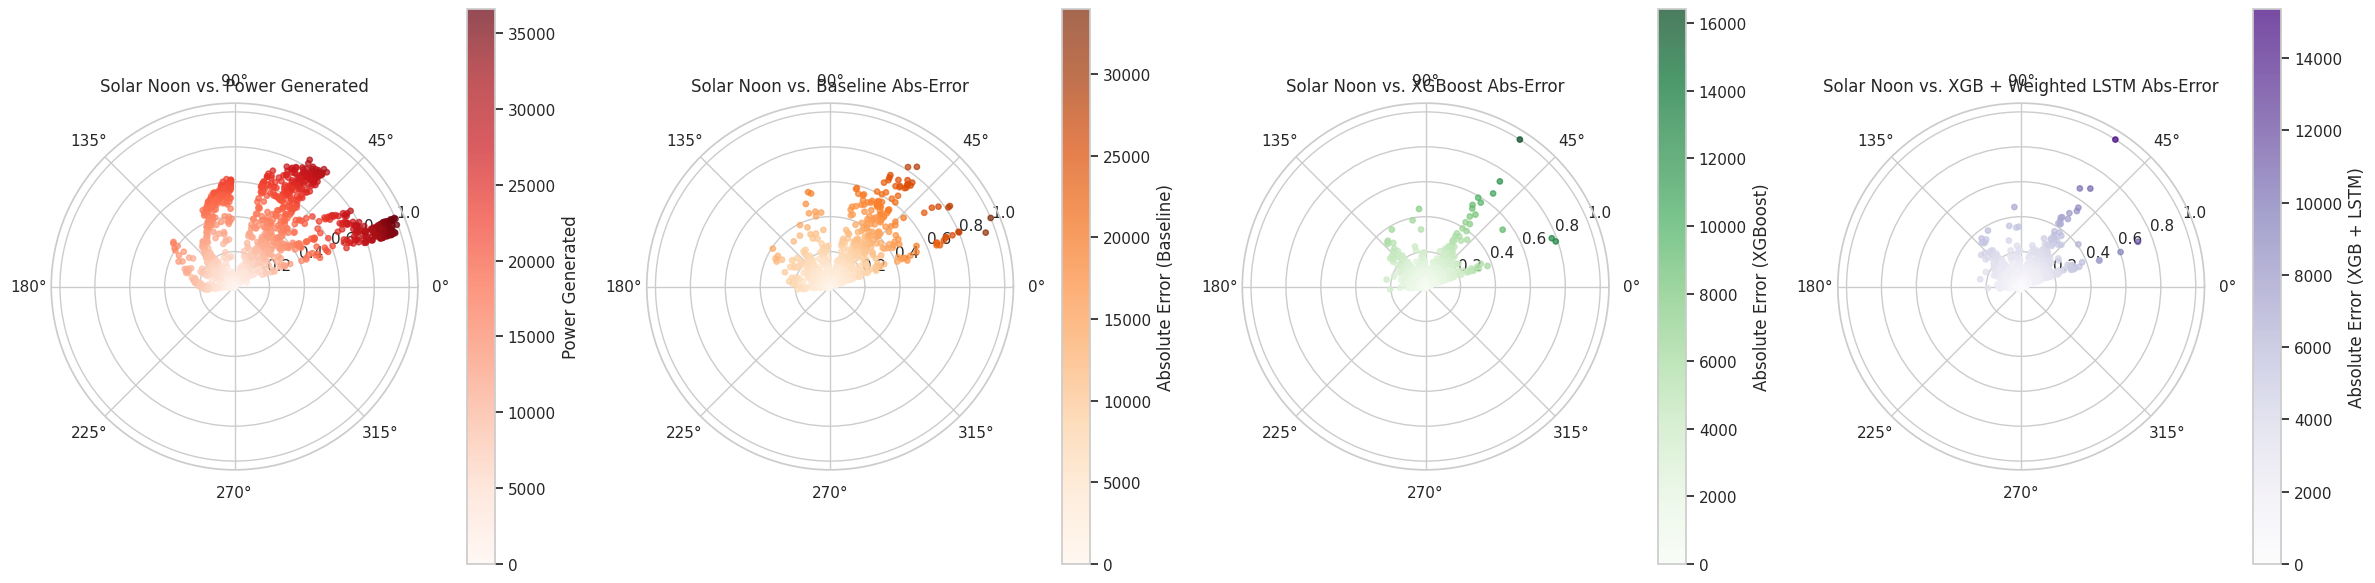

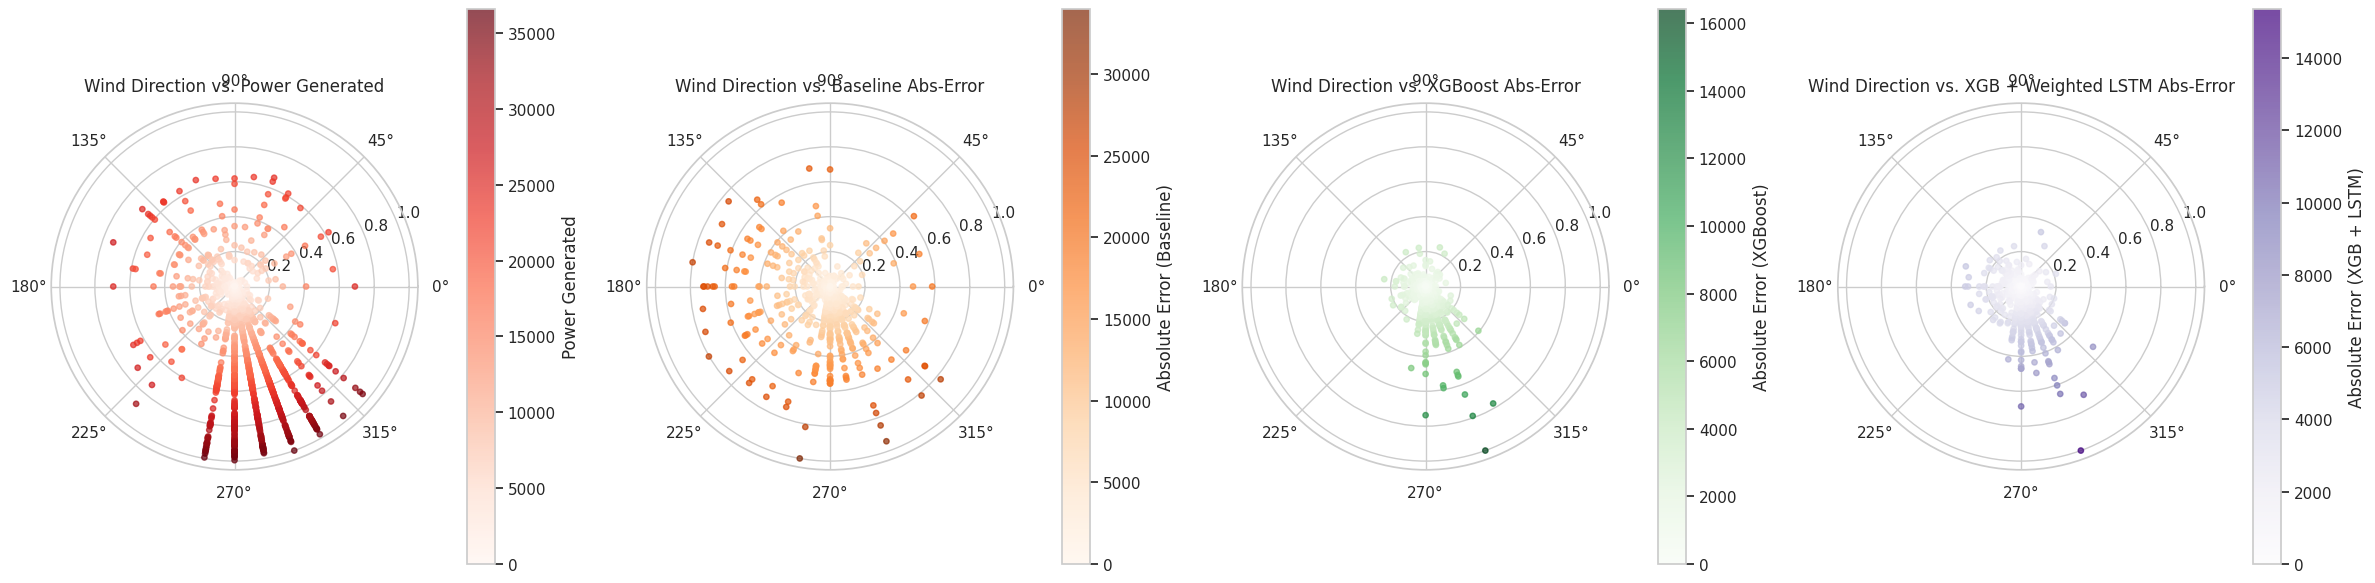

In [27]:
def plot_polar_errors_with_lstm_auto(df_seq_pred, angle_sin, angle_cos, title_prefix):
    """
    Polar plots for actual power, baseline error, XGBoost error, and XGBoost + Weighted LSTM error.
    Works directly with df_seq_pred containing 'power_pred_seq_weighted_clipped'.
    """
    # Compute angle from sin/cos
    theta = np.arctan2(df_seq_pred[angle_sin], df_seq_pred[angle_cos]) % (2*np.pi)

    # Values
    r_power = df_seq_pred['power-generated'].values.reshape(-1,1)
    r_baseline_error = np.abs(df_seq_pred['power-generated'] - df_seq_pred['baseline_clear_sky_peak3']).values.reshape(-1,1)
    r_xgb_error = np.abs(df_seq_pred['power-generated'] - df_seq_pred['power_pred_xgb_clipped']).values.reshape(-1,1)
    r_xgb_lstm_error = np.abs(df_seq_pred['power-generated'] - df_seq_pred['power_pred_seq_weighted_clipped']).values.reshape(-1,1)

    # Scale each for plotting
    scaler = MinMaxScaler()
    r_power_scaled = scaler.fit_transform(r_power).flatten()
    r_baseline_scaled = scaler.fit_transform(r_baseline_error).flatten()
    r_xgb_scaled = scaler.fit_transform(r_xgb_error).flatten()
    r_xgb_lstm_scaled = scaler.fit_transform(r_xgb_lstm_error).flatten()

    plt.figure(figsize=(24,6))

    ax1 = plt.subplot(1,4,1, polar=True)
    sc1 = ax1.scatter(theta, r_power_scaled, c=r_power.flatten(), cmap='Reds', alpha=0.7, s=15)
    ax1.set_title(f"{title_prefix} vs. Power Generated", va='bottom')
    plt.colorbar(sc1, ax=ax1, pad=0.1, label='Power Generated')

    ax2 = plt.subplot(1,4,2, polar=True)
    sc2 = ax2.scatter(theta, r_baseline_scaled, c=r_baseline_error.flatten(), cmap='Oranges', alpha=0.7, s=15)
    ax2.set_title(f"{title_prefix} vs. Baseline Abs-Error", va='bottom')
    plt.colorbar(sc2, ax=ax2, pad=0.1, label='Absolute Error (Baseline)')

    ax3 = plt.subplot(1,4,3, polar=True)
    sc3 = ax3.scatter(theta, r_xgb_scaled, c=r_xgb_error.flatten(), cmap='Greens', alpha=0.7, s=15)
    ax3.set_title(f"{title_prefix} vs. XGBoost Abs-Error", va='bottom')
    plt.colorbar(sc3, ax=ax3, pad=0.1, label='Absolute Error (XGBoost)')

    ax4 = plt.subplot(1,4,4, polar=True)
    sc4 = ax4.scatter(theta, r_xgb_lstm_scaled, c=r_xgb_lstm_error.flatten(), cmap='Purples', alpha=0.7, s=15)
    ax4.set_title(f"{title_prefix} vs. XGB + Weighted LSTM Abs-Error", va='bottom')
    plt.colorbar(sc4, ax=ax4, pad=0.1, label='Absolute Error (XGB + LSTM)')

    plt.tight_layout()
    plt.show()

# Usage with df_seq_pred
plot_polar_errors_with_lstm_auto(df_seq_pred, 'solar_noon_sin', 'solar_noon_cos', "Solar Noon")
plot_polar_errors_with_lstm_auto(df_seq_pred, 'wind_dir_sin', 'wind_dir_cos', "Wind Direction")
